In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

import netket as nk

from scipy.sparse.linalg import eigsh

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jax.random.PRNGKey(0)

### Trees

In [3]:
# this sums all square elements of a tree
euclid_norm_sq = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a**2), v))

t_sum = lambda u,v: jax.tree_util.tree_map(lambda x,y:x+y, u,v)
t_sub = lambda u,v: jax.tree_util.tree_map(lambda x,y:x-y, u,v)
t_mul = lambda u,v: jax.tree_util.tree_map(lambda x,y:x*y, u,v)
t_div = lambda u,v: jax.tree_util.tree_map(lambda x,y:x/y, u,v)
s_mul = lambda s,v: jax.tree_util.tree_map(lambda x: s*x, v)

t_zeros_like = lambda v: jax.tree_util.tree_map(lambda a: a*0, v)
t_ones_like = lambda v: jax.tree_util.tree_map(lambda a: a*0 + 1, v)

## Hamiltonian

$$
H = -h\sum_{i}S_i^{(x)} + J \sum_{<i,j>} S_i^{(z)} S_j^{(z)}
$$

In [4]:
# Define a grid
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

# This creates an empty operator (or zero) to which you can add others.
h = 1.
J = 1.

hamiltonian = nk.operator.LocalOperator(hi)

# now add all terms acting on single sites
for site in g.nodes():
    hamiltonian = hamiltonian - h* nk.operator.spin.sigmax(hi, site)

    # now add all terms acting on multiple sites
for (i,j) in g.edges():
    hamiltonian = hamiltonian + J * nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j)


hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


In [5]:
all_states = jnp.array([s for s in hi.states()])

In [6]:
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1, which = "SA")
E_f = e_gs[0]
psi_gs = psi_gs.reshape(-1)

In [7]:
def calc_H_loc(orbital, parameters, samples):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(samples)
    
    logpsi_sigma = orbital.calc_logpsi(parameters, samples)
    logpsi_eta = orbital.calc_logpsi(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res

## Construct Neural Network

In [8]:
def act(x):
    return netket.nn.activation.log_cosh(x)

In [9]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16, name="dense1", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = jnp.sum(x, axis = -1)

        return jnp.squeeze(x)

## Construct Ansatz

In [10]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (g.n_nodes,))

        self.nn = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((g.n_nodes,)))

        return {"nn": nn_param}
    
    
    def calc_logpsi(self, parameters, x):
        logpsi = self.nn.apply(parameters["nn"], x)

        return logpsi

In [11]:
ansatz = Ansatz()

## Sampler

In [48]:
class FlipSampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mask = jnp.ones((g.n_nodes))
        for i in range(self.variance):
            index = jax.random.randint(key, (), 0, g.n_nodes)
            key, _ = jax.random.split(key)
            mask = mask.at[index].multiply(-1)

        proposal = element * mask

        return subkey, proposal
sampler = FlipSampler(ansatz, 1)
subsampling = g.n_nodes
def get_samples(N, param):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, 2*jax.random.randint(key, (g.n_nodes,), 0, 2)-1 + 0., N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

### Gradient of Energy and Metric Tensor

In [13]:
@partial(jax.jit, static_argnames=['orbital'])
def calc_grad_E(orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = netket.jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: jnp.real(a-b), s1, s2)

eps = 1e-4
@partial(jax.jit, static_argnames=['ansatz'])
def apply_g(ansatz, samples, primals, tangent):
    u = eval_S(ansatz, primals, samples, tangent)
    return jax.tree_util.tree_map(lambda a, b: a + eps * b, u, tangent)

@partial(jax.jit, static_argnames=['ansatz'])
def inverse_g(ansatz, samples, primals, cotangent):
    A = lambda tangents : apply_g(ansatz, samples, primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]


#---------------------------------------------------
# in full summation
#---------------------------------------------------

def full_psi(ansatz, param):
    return ansatz.calc_psi(param, all_states)

def full_lnK(ansatz, param):
    psi = ansatz.calc_psi(param, all_states)
    return 0.5*jnp.log(jnp.sum(jnp.conj(psi) * psi))

def full_eval_S1(ansatz, parameters, v):
    f = lambda theta: full_psi(ansatz, theta)
    K = jnp.exp(full_lnK(ansatz, parameters))

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1 * x.real / K**2, b)

def full_eval_S2(ansatz, parameters, v):
    f = lambda theta: full_lnK(ansatz, theta)

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](jnp.array(1.))[0]
    return  jax.tree_util.tree_map(lambda v: a * v, b)

def full_eval_S(orbital, parameters, v):
    s1 = full_eval_S1(orbital, parameters, v)
    s2 = full_eval_S2(orbital, parameters, v)
    return jax.tree_util.tree_map(lambda a,b: jnp.real(a-b), s1, s2)

@partial(jax.jit, static_argnames=['ansatz'])
def full_apply_g(ansatz, primals, tangent):
    u = full_eval_S(ansatz, primals, tangent)
    return jax.tree_util.tree_map(lambda a, b: a + eps * b, u, tangent)

@partial(jax.jit, static_argnames=['ansatz'])
def full_inverse_g(ansatz, primals, cotangent):
    A = lambda tangents : full_apply_g(ansatz, primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]

### Christoffel Symbols

In [45]:
def a(ansatz, samples, primals, gamma_dot):
    f = lambda primals : apply_g(ansatz, samples, primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def a_approx(ansatz, samples, old_samples, gamma, old_gamma, gamma_dot, epsilon):
    x = s_mul(1/epsilon, t_sub(apply_g(ansatz, samples, gamma, gamma_dot), apply_g(ansatz, old_samples, old_gamma, gamma_dot)))
    return x


def b(ansatz, samples, primals, gamma_dot):

    ## this sums all elements of a tree
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))

    ## this computes the norm square of gamma dot
    f = lambda primals : g(jax.tree_util.tree_map(lambda c, d : c * d, gamma_dot, apply_g(ansatz, samples, primals, gamma_dot)))
    
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@partial(jax.jit, static_argnames=['ansatz'])
def geodesic_correction(ansatz, samples, primals, gamma_dot):
    lower = jax.tree_util.tree_map(lambda c,d: 2*c - d, a(ansatz, samples, primals, gamma_dot), b(ansatz, samples, primals, gamma_dot))
    return jax.tree_util.tree_map(lambda k:0.5*k, lower)

@partial(jax.jit, static_argnames=['ansatz'])
def geodesic_correction_approx(ansatz, samples, old_samples, primals, old_primals, gamma_dot, epsilon):
    lower = jax.tree_util.tree_map(lambda c,d: 2*c - d, a_approx(ansatz, samples, old_samples, primals, old_primals, gamma_dot, epsilon), b(ansatz, samples, primals, gamma_dot))
    return jax.tree_util.tree_map(lambda k:0.5*k, lower)

#------------------------------------------------------
#  in ful summation
#------------------------------------------------------

def full_a(ansatz, primals, gamma_dot):
    f = lambda primals : full_apply_g(ansatz, primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def full_b(ansatz, primals, gamma_dot):

    ## this sums all elements of a tree
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))

    ## this computes the norm square of gamma dot
    f = lambda primals : g(jax.tree_util.tree_map(lambda c, d : c * d, gamma_dot, full_apply_g(ansatz, primals, gamma_dot)))
    
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@partial(jax.jit, static_argnames=['ansatz'])
def full_geodesic_correction(ansatz, primals, gamma_dot):
    lower = jax.tree_util.tree_map(lambda c,d: 2*c - d, full_a(ansatz, primals, gamma_dot), full_b(ansatz, primals, gamma_dot))
    return jax.tree_util.tree_map(lambda k:0.5*k, lower)

### Covariant Norm

In [15]:
def calc_norm_square(ansatz, samples, primals, tangent):
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))
    return  g(jax.tree_util.tree_map(lambda c, d : c * d, tangent, apply_g(ansatz, samples, primals, tangent)))

def full_calc_norm_square(ansatz, primals, tangent):
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))
    return  g(jax.tree_util.tree_map(lambda c, d : c * d, tangent, full_apply_g(ansatz, primals, tangent)))

## Geodesics
We try to first accurately simulate geodesic motion on the variational manifold. Therefore, we discretise the geodesic equation and obtain:
$$
\gamma^i(t + \epsilon) = 2\gamma(t)^i  - \gamma^i(t-\epsilon) - \Gamma^i_{jk}(\gamma^j(t)-\gamma^j(t-\epsilon))(\gamma^k(t)-\gamma^k(t-\epsilon))
$$

In [98]:
def full_geodesic(param, param_dot, N = 10, epsilon = 0.01):
    stats = {"momentum":[], "test": []}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)

    for i in tqdm(range(N)):
        delta_param = t_sub(param, old_param)
        param_dot = s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = full_inverse_g(ansatz, param, full_geodesic_correction(ansatz, param, delta_param))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - cor, param, old_param, cor)
        old_param = param
        param = new_param

    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


def geodesic(param, param_dot, N = 10, epsilon = 0.01, N_samples = 5000):
    stats = {"momentum":[]}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)

    for i in tqdm(range(N)):

        samples, _ = get_samples(N_samples, param)
        delta_param = t_sub(param, old_param)
        param_dot = s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = inverse_g(ansatz, param, samples, geodesic_correction(ansatz, samples, param, delta_param))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - cor, param, old_param, cor)
        old_param = param
        param = new_param



    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


def geodesic_approx(param, param_dot, N = 10, epsilon = 0.01, N_samples = 5000):
    stats = {"momentum":[]}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)
    old_samples, _ = get_samples(N_samples, old_param)

    for i in tqdm(range(N)):

        samples, _ = get_samples(N_samples, param)
        delta_param = t_sub(param, old_param)
        param_dot = s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = inverse_g(ansatz, param, samples, geodesic_correction_approx(ansatz, samples, old_samples, param, old_param, param_dot, epsilon))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - epsilon**2*cor, param, old_param, cor)
        old_param = param
        param = new_param

        old_samples = samples

    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


In [ ]:
def full_geodesic(param, param_dot, N = 10, epsilon = 0.01):
    stats = {"momentum":[], "test": []}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)

    for i in tqdm(range(N)):
        delta_param = t_sub(param, old_param)
        param_dot = s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = full_inverse_g(ansatz, param, full_geodesic_correction(ansatz, param, delta_param))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - cor, param, old_param, cor)
        old_param = param
        param = new_param

    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


def geodesic(param, param_dot, N = 10, epsilon = 0.01, N_samples = 5000):
    stats = {"momentum":[]}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)

    for i in tqdm(range(N)):

        samples, _ = get_samples(N_samples, param)
        delta_param = t_sub(param, old_param)
        param_dot = s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = inverse_g(ansatz, param, samples, geodesic_correction(ansatz, samples, param, delta_param))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - cor, param, old_param, cor)
        old_param = param
        param = new_param



    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


def geodesic_approx(param, param_dot, N = 10, epsilon = 0.01, N_samples = 5000):
    stats = {"momentum":[]}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)
    old_samples, _ = get_samples(N_samples, old_param)

    for i in tqdm(range(N)):

        samples, _ = get_samples(N_samples, param)
        delta_param = t_sub(param, old_param)
        param_dot = s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = inverse_g(ansatz, param, samples, geodesic_correction_approx(ansatz, samples, old_samples, param, old_param, param_dot, epsilon))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - epsilon**2*cor, param, old_param, cor)
        old_param = param
        param = new_param

        old_samples = samples

    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


In [224]:
key, _ = jax.random.split(key)
param = ansatz.init_param(key)
N = 100
epsilon = 0.01

param_dot = s_mul(0.01, t_ones_like(param))
init_norm = full_calc_norm_square(ansatz, param, param_dot)

full_stats = full_geodesic(param, param_dot , N, epsilon)
stats = geodesic(param, param_dot, N, epsilon, N_samples=5000)
stats_approx = geodesic_approx(param, param_dot, N, epsilon, N_samples=5000)

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [226]:
# np.savetxt("full_stats_eps=1e-2", full_stats["momentum"])
# np.savetxt("stats_eps=1e-2", stats["momentum"])
# np.savetxt("stats_approx_eps=1e-2", stats_approx["momentum"])

## Evaluate accuracy

(0.0, 0.01)

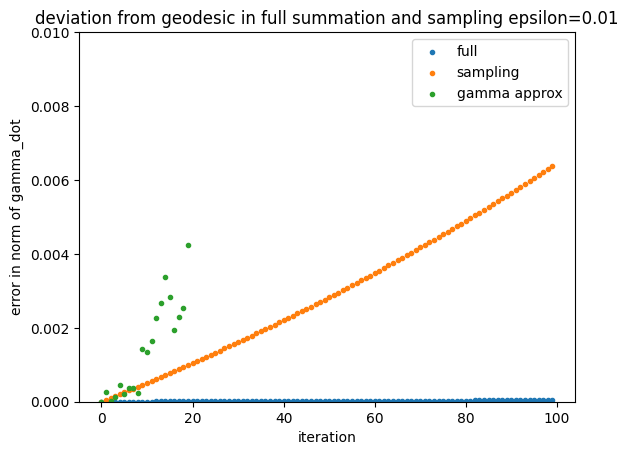

In [235]:
i = jnp.arange(N)

plt.scatter(i, jnp.abs(full_stats["momentum"] - init_norm), label = "full", marker = ".")
plt.scatter(i, jnp.abs(stats["momentum"] - init_norm), label = "sampling", marker =".")
plt.scatter(i, jnp.abs(stats_approx["momentum"] - init_norm), label = "gamma approx", marker =".")

# plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("error in norm of gamma_dot")
plt.legend()
plt.title("deviation from geodesic in full summation and sampling epsilon="+str(epsilon))
plt.ylim(0, 0.01)


In [215]:
key, _ = jax.random.split(key)
N_samples = 5000
param = ansatz.init_param(key)
param_dot = s_mul(0.01, t_ones_like(param))
samples, _ = get_samples(N_samples, param)
x2 = geodesic_correction(ansatz, samples, param, param_dot)

errs = []
eps = 10**(-jnp.arange(20,50)*0.1 + 0.)
for epsilon in eps:
    old_param = t_sub(param, s_mul(epsilon, param_dot))
    old_samples, _ = get_samples(N_samples, old_param)
    x1 = geodesic_correction_approx(ansatz, samples, old_samples, param, old_param, param_dot, epsilon)
    err = euclid_norm_sq(t_sub(x1, x2))
    # err = full_calc_norm_square(ansatz, param, t_sub(x1,x2))
    errs.append(jnp.sqrt(err))

Text(0.5, 1.0, 'geodesic correction error between Gamma and approximated Gamma (both sampled)')

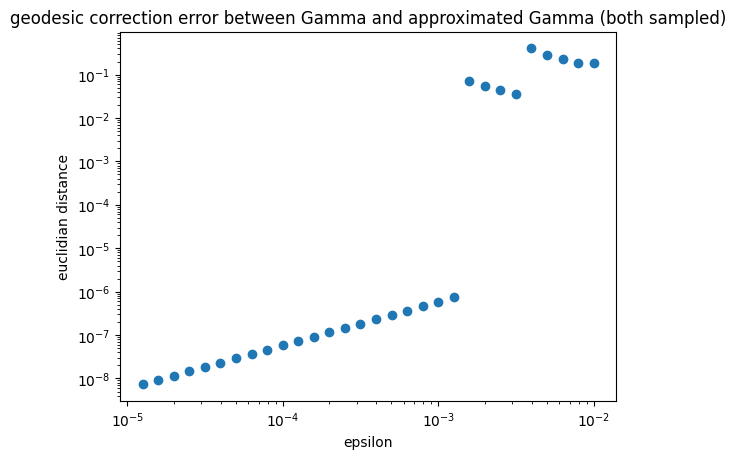

In [216]:
plt.scatter(eps, errs)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("epsilon")
plt.ylabel("euclidian distance")
plt.title("geodesic correction error between Gamma and approximated Gamma (both sampled)")

---